# Automatic forecast with models fo StatsForecast

In [15]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, AutoARIMA, AutoETS, AutoTheta, AutoCES
from utilsforecast.plotting import plot_series
import warnings

warnings.filterwarnings("ignore")

_session_dir = Path(os.getcwd()).parent

print(datetime.now())

2024-03-08 03:08:45.649038


## Loadind data from s3

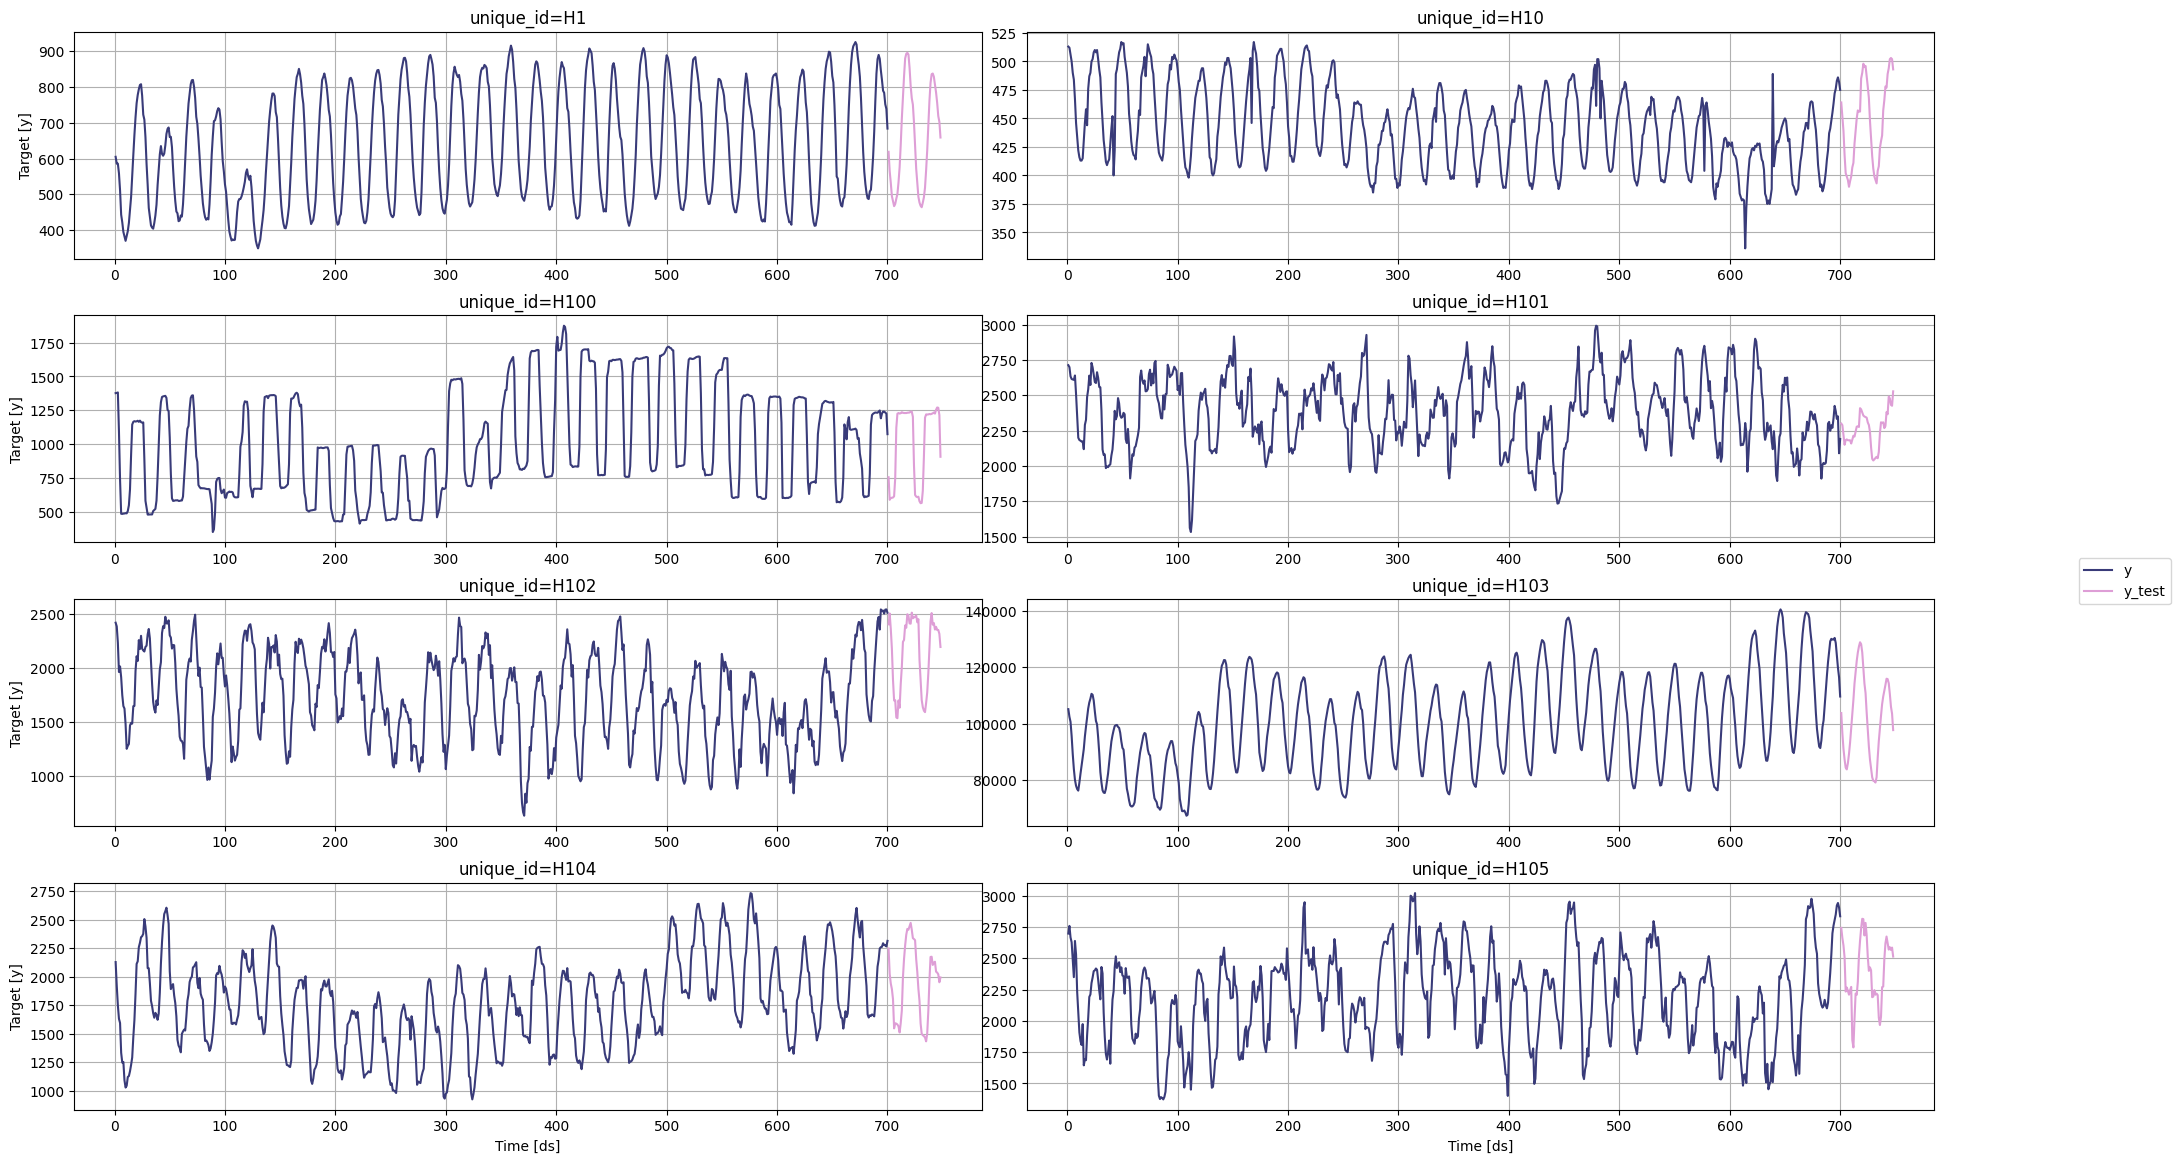

In [33]:
train = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly.csv')
test = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly-test.csv').rename(columns={'y': 'y_test'})

n_series = 8 
uids = train['unique_id'].unique()[:n_series] # select first n_series of the dataset
train = train.query('unique_id in @uids')
test = test.query('unique_id in @uids')

StatsForecast.plot(train, test, plot_random = False)

## Training models

In [30]:

# Create a list of models and instantiation parameters 
season_length = 24
models = [
    Naive(), 
    SeasonalNaive(season_length=season_length),
    AutoARIMA(season_length=season_length), # ARIMA model with automatic order selection and seasonal component
    AutoETS(season_length=season_length), # ETS model with automatic error, trend, and seasonal component
    AutoTheta(season_length=season_length), # Theta model with automatic seasonality detection
    AutoCES(season_length=season_length), # CES model with automatic seasonality detection
]


sf = StatsForecast(
    df=train, 
    models=models, 
    freq=1, 
    n_jobs=-1
)

levels = [80, 90, 95, 99] # confidence levels of the prediction intervals 
forecasts = sf.forecast(h=48, level=levels)
forecasts = forecasts.reset_index()
forecasts.head()

/Users/jorge/Documents/vaforecast/.venv/lib/python3.11/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),
/Users/jorge/Documents/vaforecast/.venv/lib/python3.11/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),
/Users/jorge/Documents/vaforecast/.venv/lib/python3.11/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),
/Users/jorge/Documents/vaforecast/.venv/lib/python3.11/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version

unique_id   ds  Naive  Naive-lo-80  Naive-lo-90  Naive-lo-95  Naive-lo-99  \
0        H1  701  684.0   631.645569   616.803833   603.930786   578.771240   
1        H1  702  684.0   609.959656   588.970215   570.765076   535.184082   
2        H1  703  684.0   593.319458   567.612793   545.316101   501.738434   
3        H1  704  684.0   579.291138   549.607605   523.861633   473.542480   
4        H1  705  684.0   566.931946   533.744751   504.959839   448.701355   

   Naive-hi-80  Naive-hi-90  Naive-hi-95  ...  AutoTheta-hi-99         CES  \
0   736.354431   751.196167   764.069214  ...       645.520142  621.200012   
1   758.040344   779.029785   797.234924  ...       591.472290  556.268921   
2   774.680542   800.387207   822.683899  ...       547.892090  512.232849   
3   788.708862   818.392395   844.138367  ...       523.679077  479.324799   
4   801.068054   834.255249   863.040161  ...       496.285889  457.910278   

    CES-lo-99   CES-lo-95   CES-lo-90   CES-lo-80   CES-hi-80   CES-hi-90  \
0  571.628967  583.482239  589.600952  596.384644  645.960266  653.240234   
1  508.520142  518.294739  523.535156  530.860962  581.035828  588.951843   
2  461.393036  473.811981  479.590698  486.654694  537.072144  544.543213   
3  429.126648  440.171753  446.240814  453.954651  505.002136  512.115723   
4  408.922058  420.353729  426.041290  432.896301  482.963196  490.158264   

    CES-hi-95   CES-hi-99  
0  658.711975  670.629456  
1  595.159180  605.363525  
2  550.725159  563.506287  
3  519.576233  531.300293  
4  496.334198  509.547394  

[5 rows x 56 columns]

In [34]:
test = test.merge(forecasts, how='left', on=['unique_id', 'ds'])
test.head()

unique_id   ds  y_test  Naive  Naive-lo-80  Naive-lo-90  Naive-lo-95  \
0        H1  701   619.0  684.0   631.645569   616.803833   603.930786   
1        H1  702   565.0  684.0   609.959656   588.970215   570.765076   
2        H1  703   532.0  684.0   593.319458   567.612793   545.316101   
3        H1  704   495.0  684.0   579.291138   549.607605   523.861633   
4        H1  705   481.0  684.0   566.931946   533.744751   504.959839   

   Naive-lo-99  Naive-hi-80  Naive-hi-90  ...  AutoTheta-hi-99         CES  \
0   578.771240   736.354431   751.196167  ...       645.520142  621.200012   
1   535.184082   758.040344   779.029785  ...       591.472290  556.268921   
2   501.738434   774.680542   800.387207  ...       547.892090  512.232849   
3   473.542480   788.708862   818.392395  ...       523.679077  479.324799   
4   448.701355   801.068054   834.255249  ...       496.285889  457.910278   

    CES-lo-99   CES-lo-95   CES-lo-90   CES-lo-80   CES-hi-80   CES-hi-90  \
0  571.628967  583.482239  589.600952  596.384644  645.960266  653.240234   
1  508.520142  518.294739  523.535156  530.860962  581.035828  588.951843   
2  461.393036  473.811981  479.590698  486.654694  537.072144  544.543213   
3  429.126648  440.171753  446.240814  453.954651  505.002136  512.115723   
4  408.922058  420.353729  426.041290  432.896301  482.963196  490.158264   

    CES-hi-95   CES-hi-99  
0  658.711975  670.629456  
1  595.159180  605.363525  
2  550.725159  563.506287  
3  519.576233  531.300293  
4  496.334198  509.547394  

[5 rows x 57 columns]

## Naive

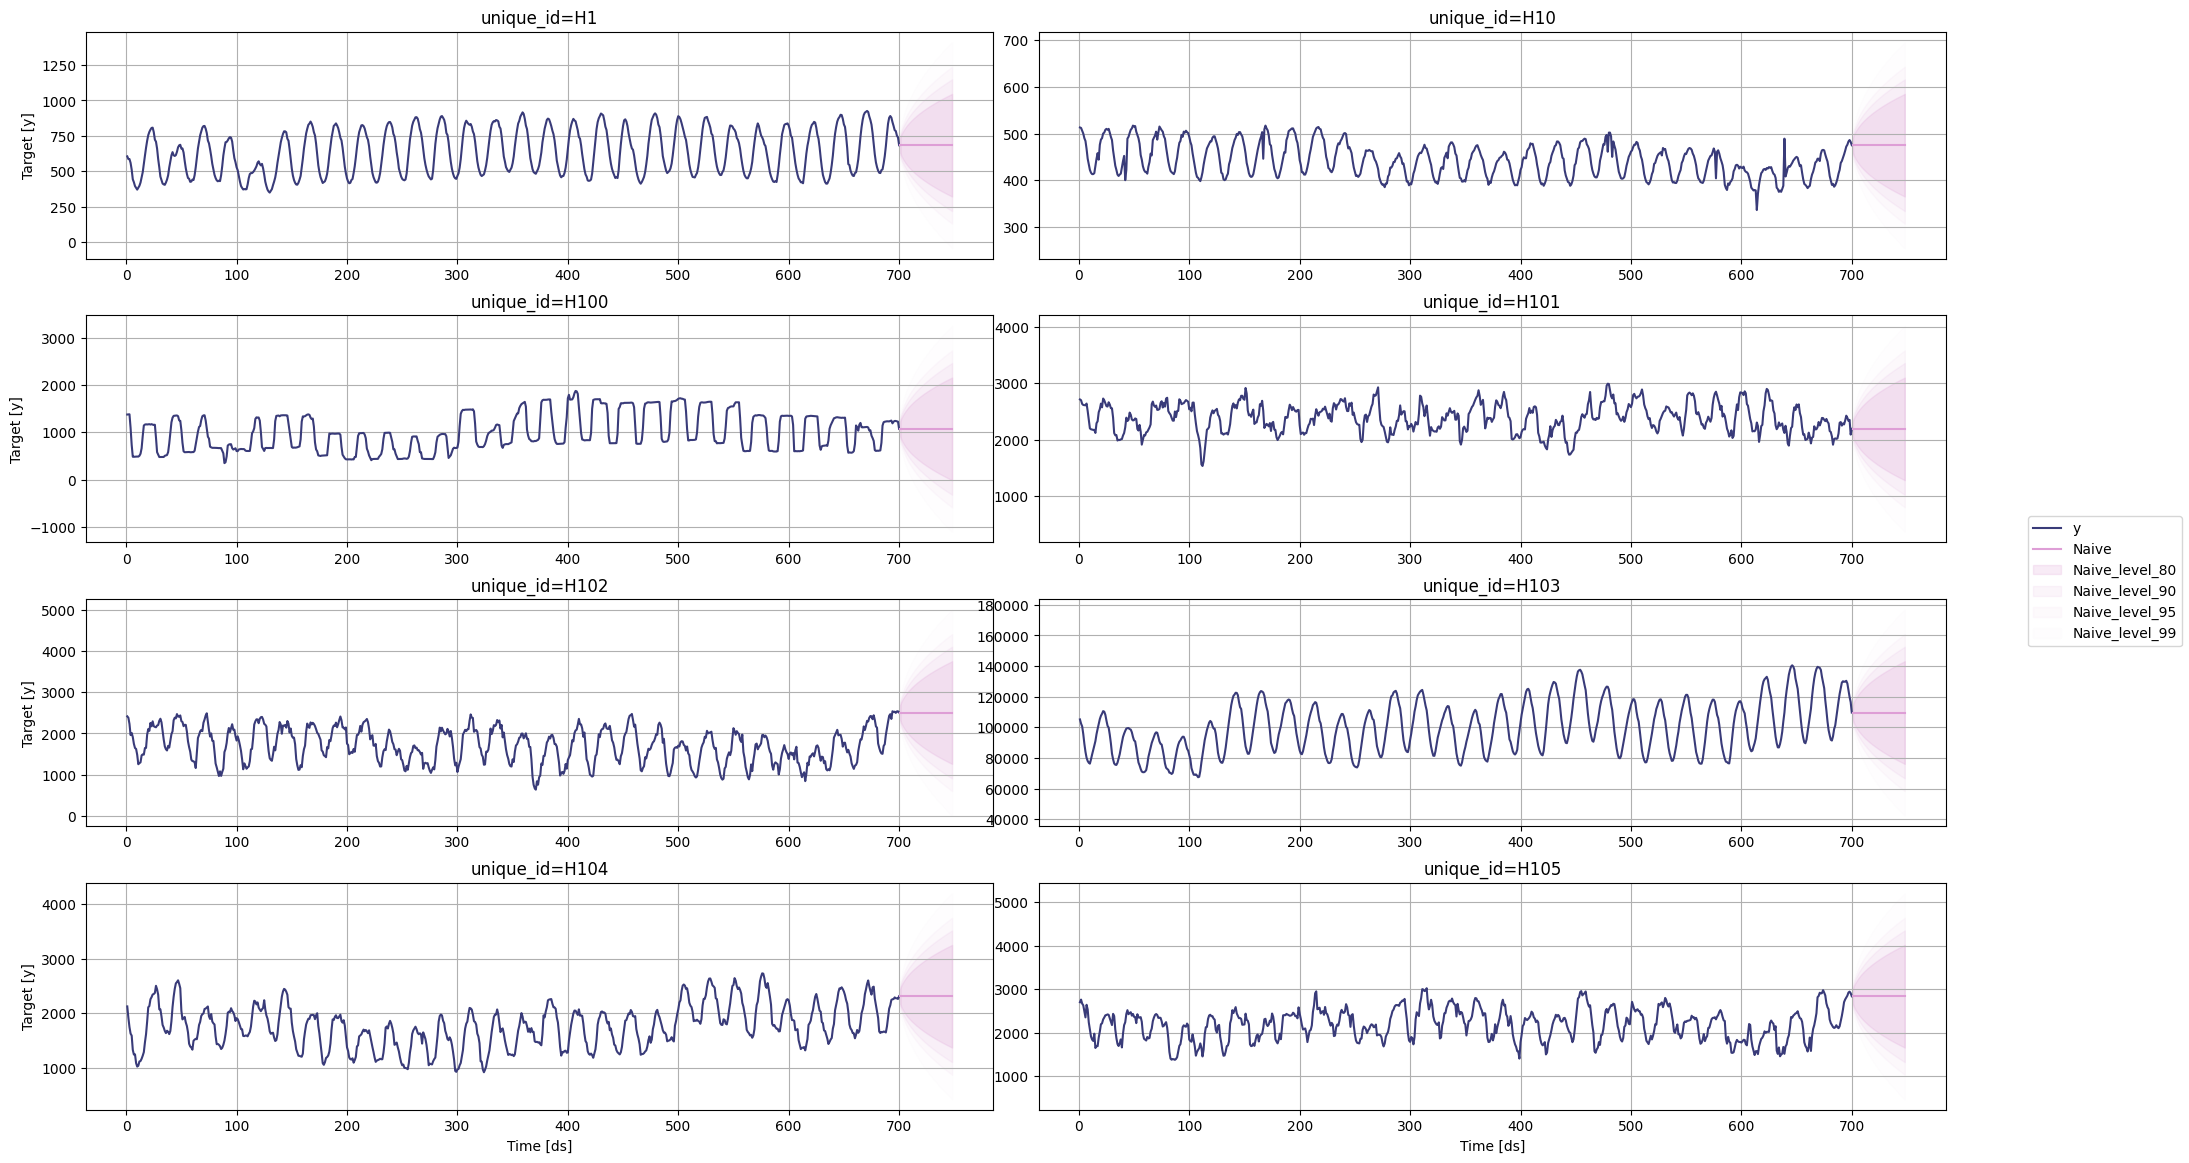

In [36]:
sf.plot(train, test, plot_random = False, models=['Naive'], level=levels)

## SeasonalNaive

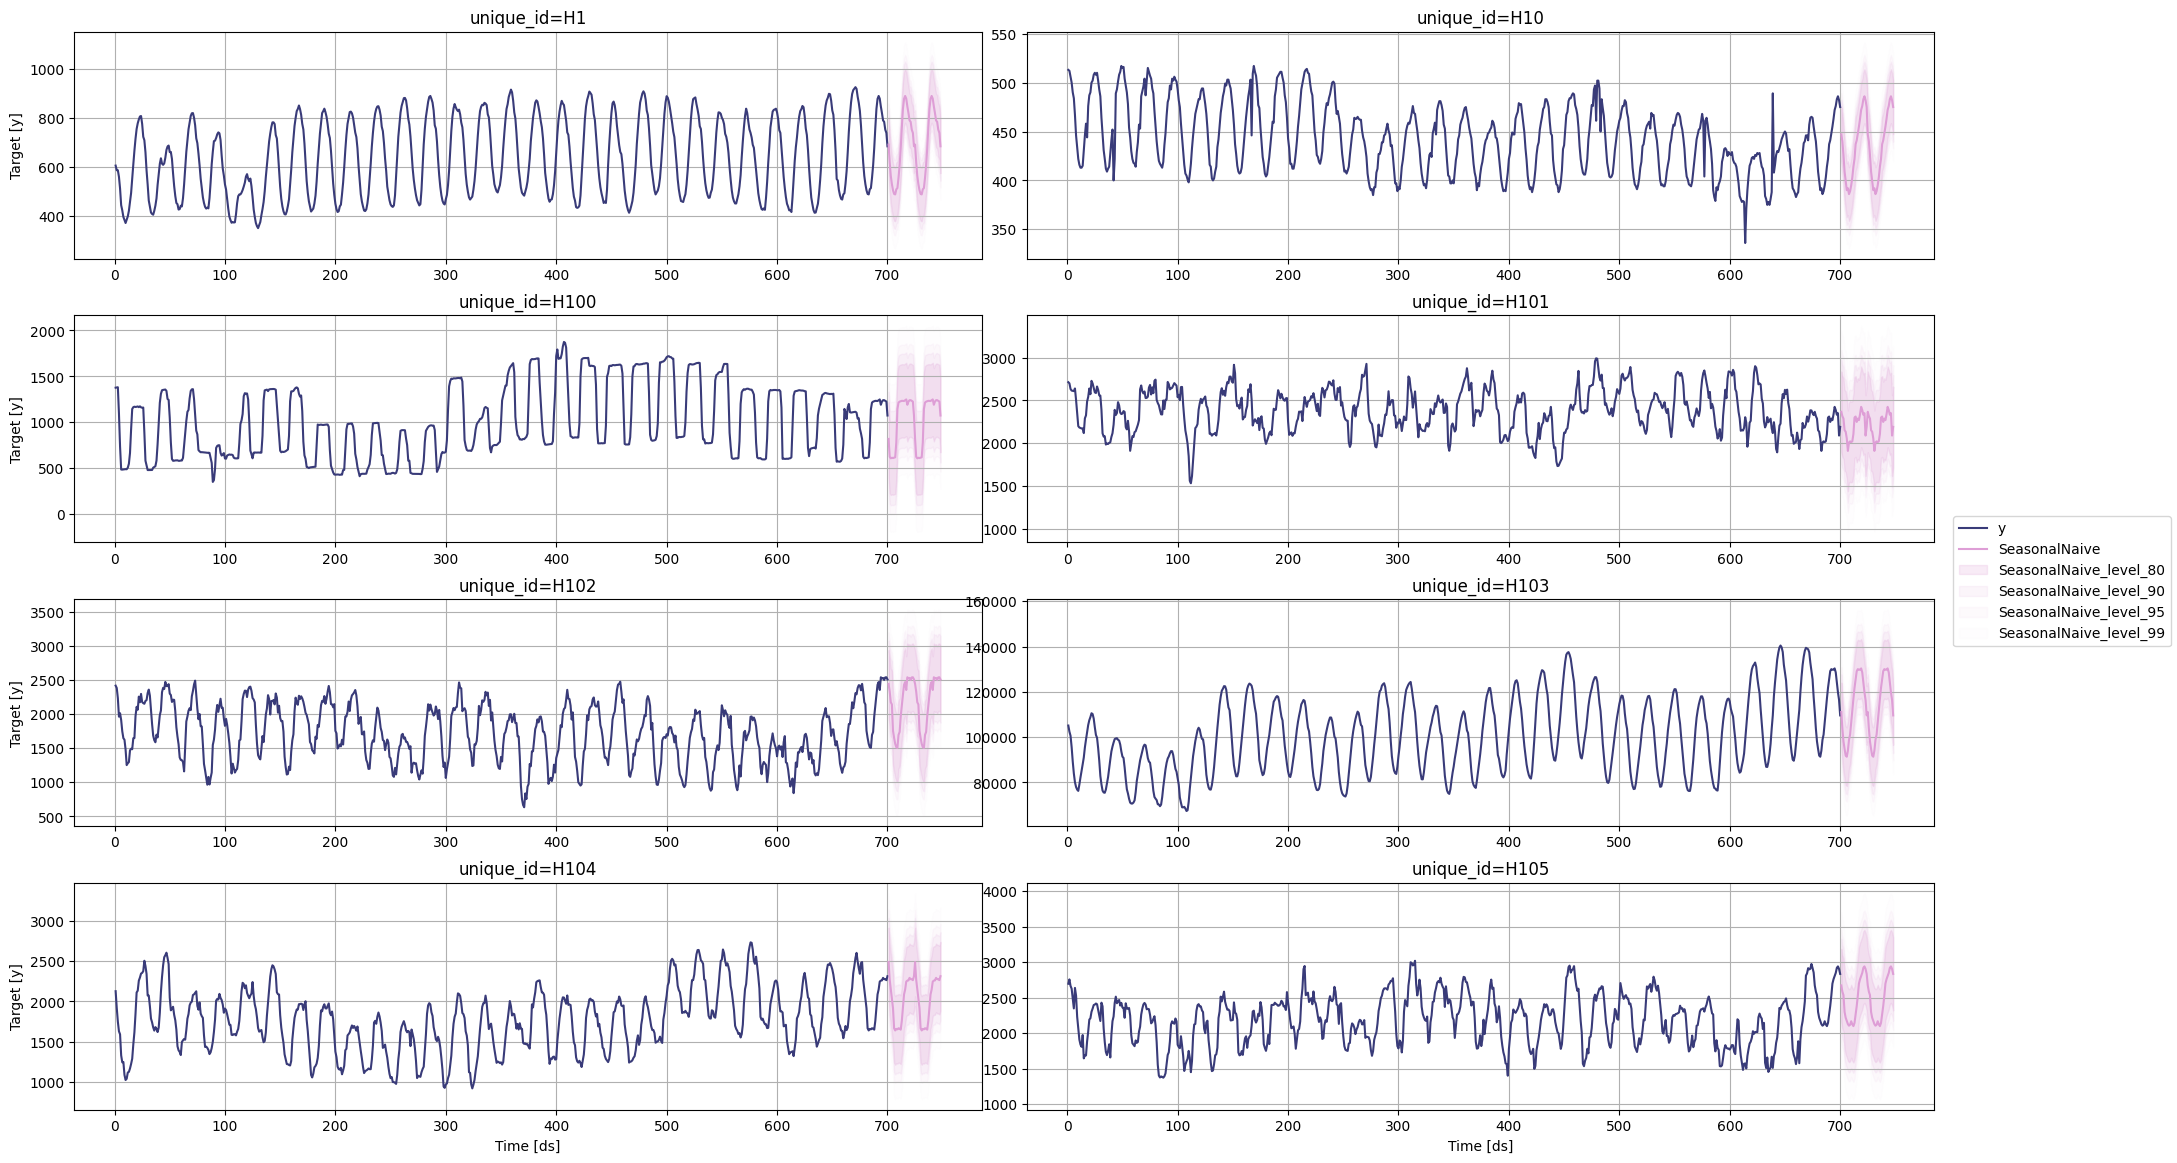

In [37]:
sf.plot(train, test, plot_random = False, models=['SeasonalNaive'], level=levels)

## AutoARIMA

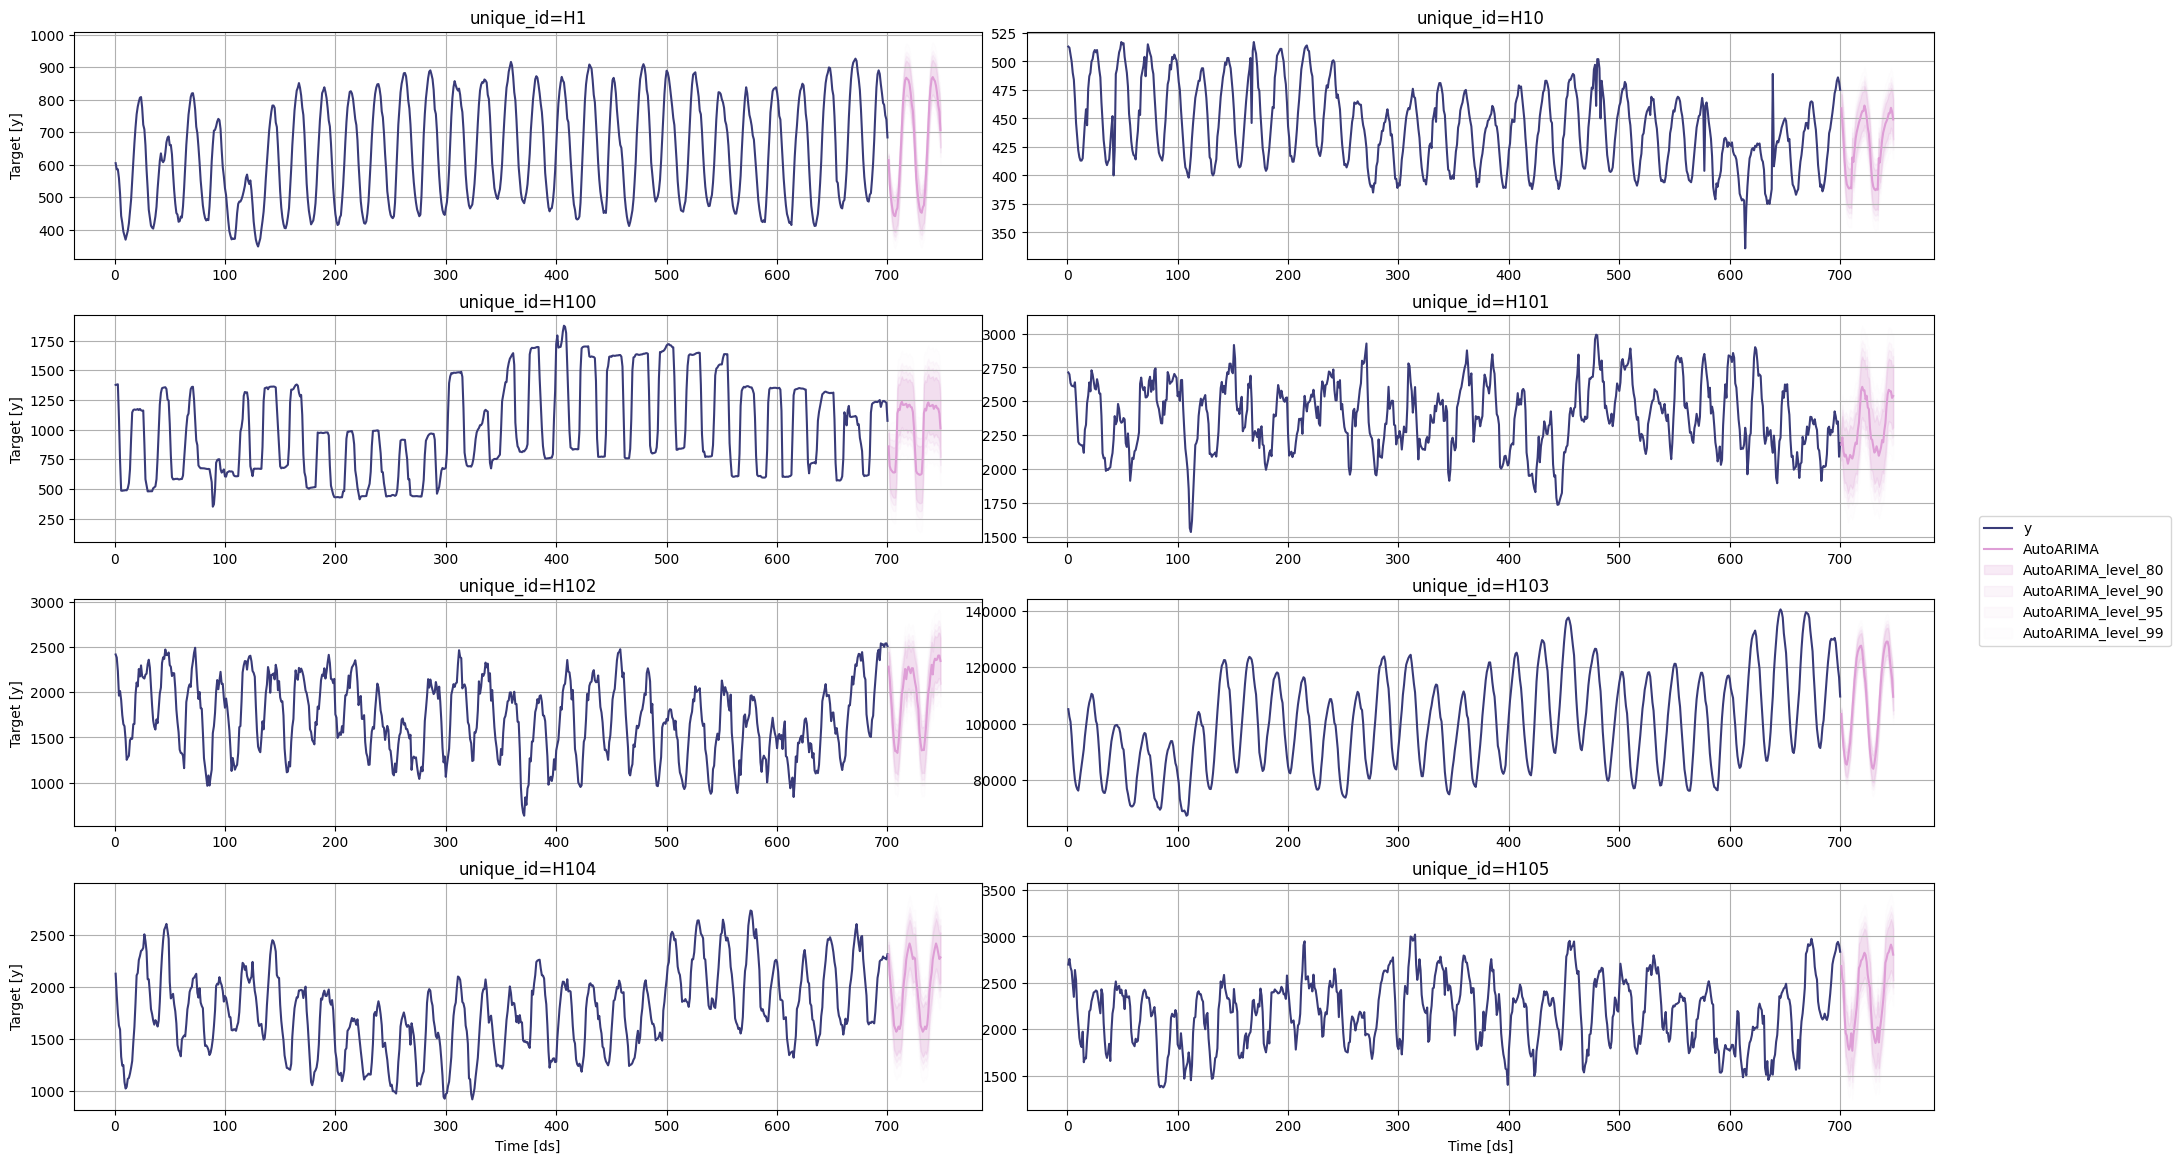

In [38]:
sf.plot(train, test, plot_random = False, models=['AutoARIMA'], level=levels)

## AutoETS

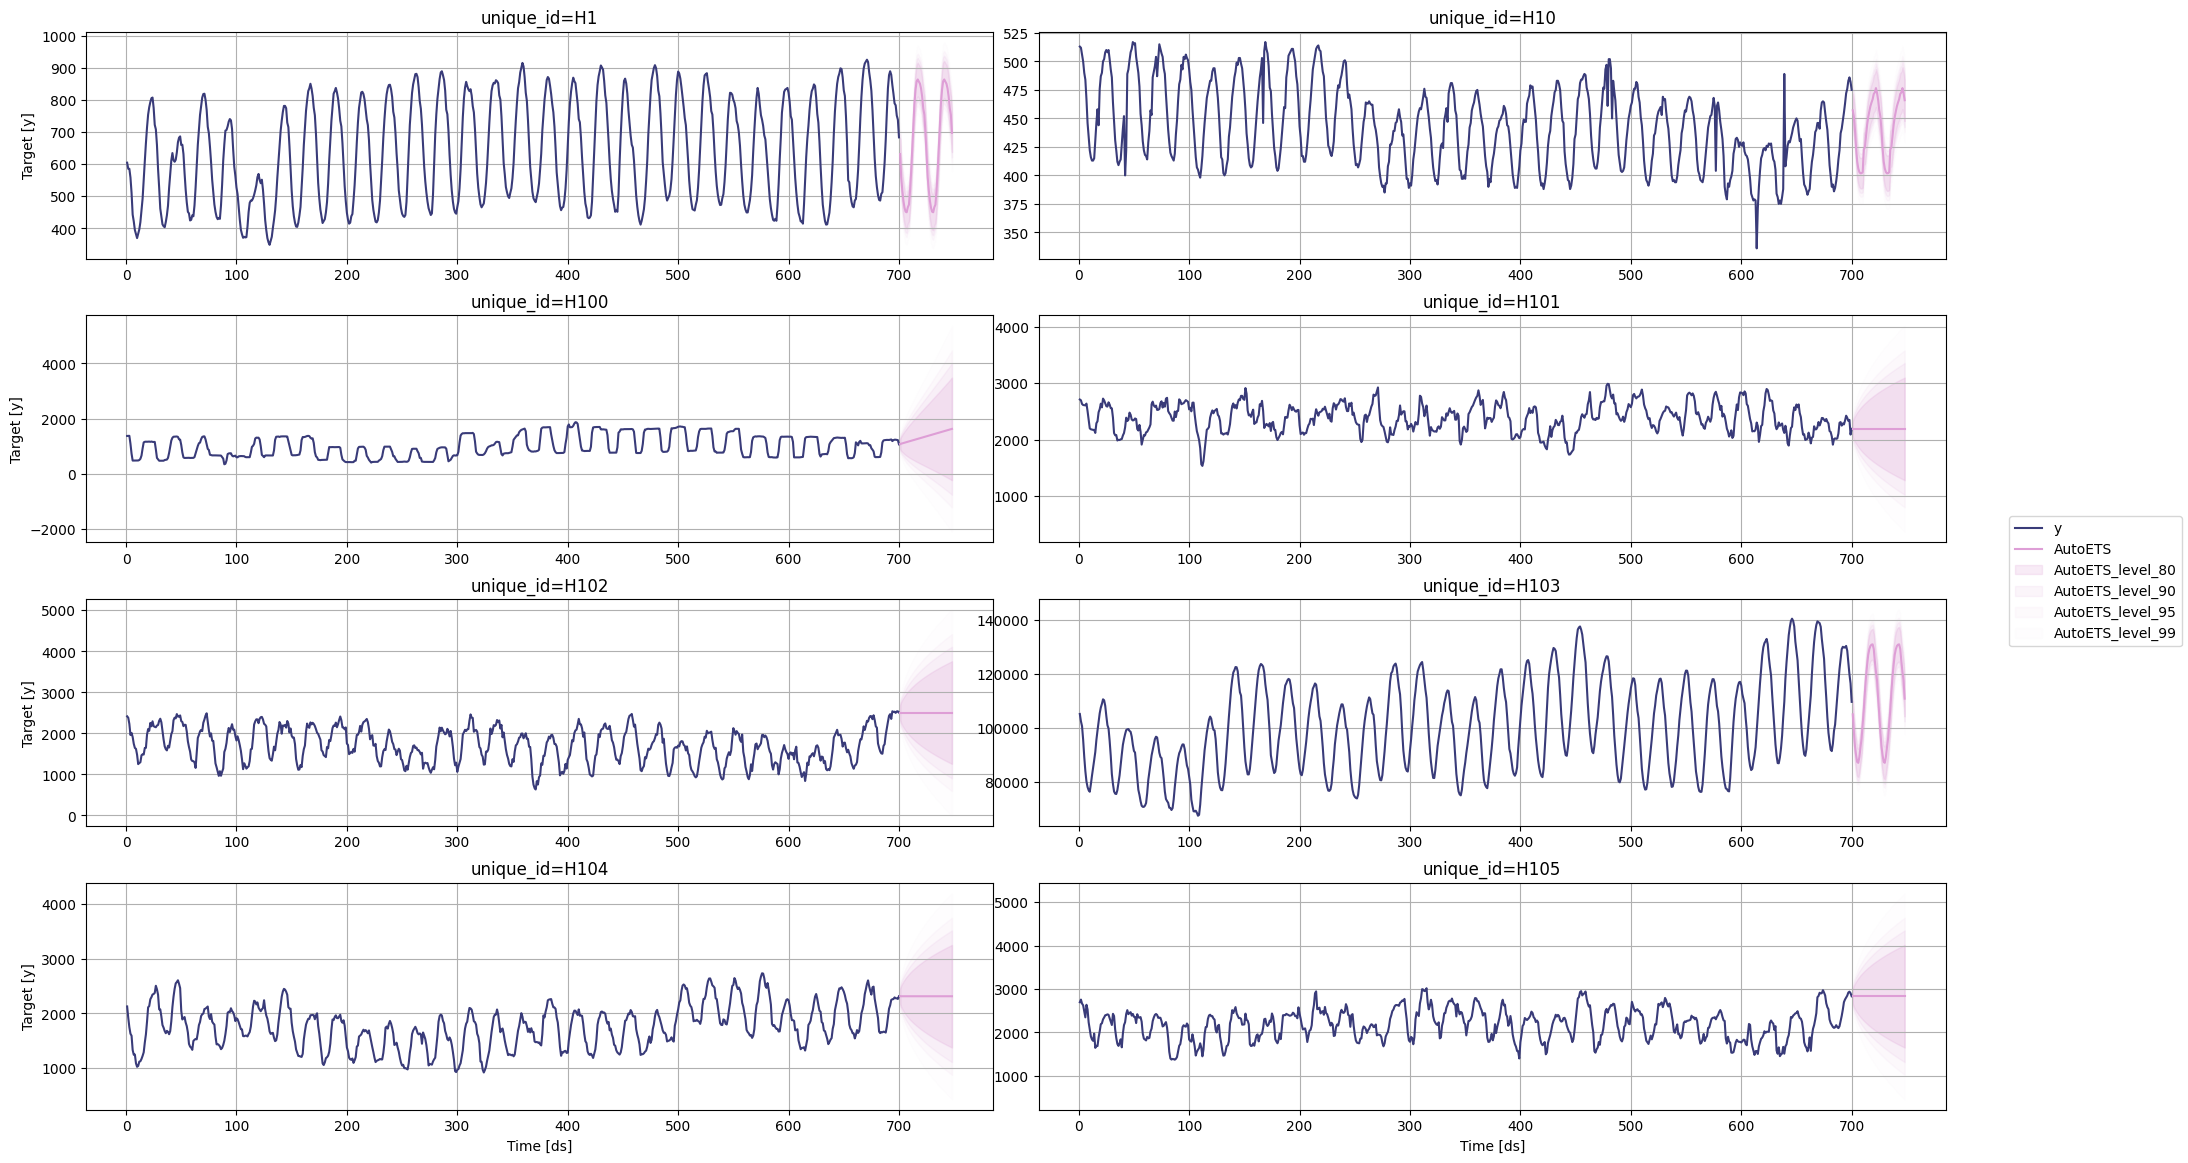

In [35]:
sf.plot(train, test, plot_random = False, models=['AutoETS'], level=levels)

## AutoTheta

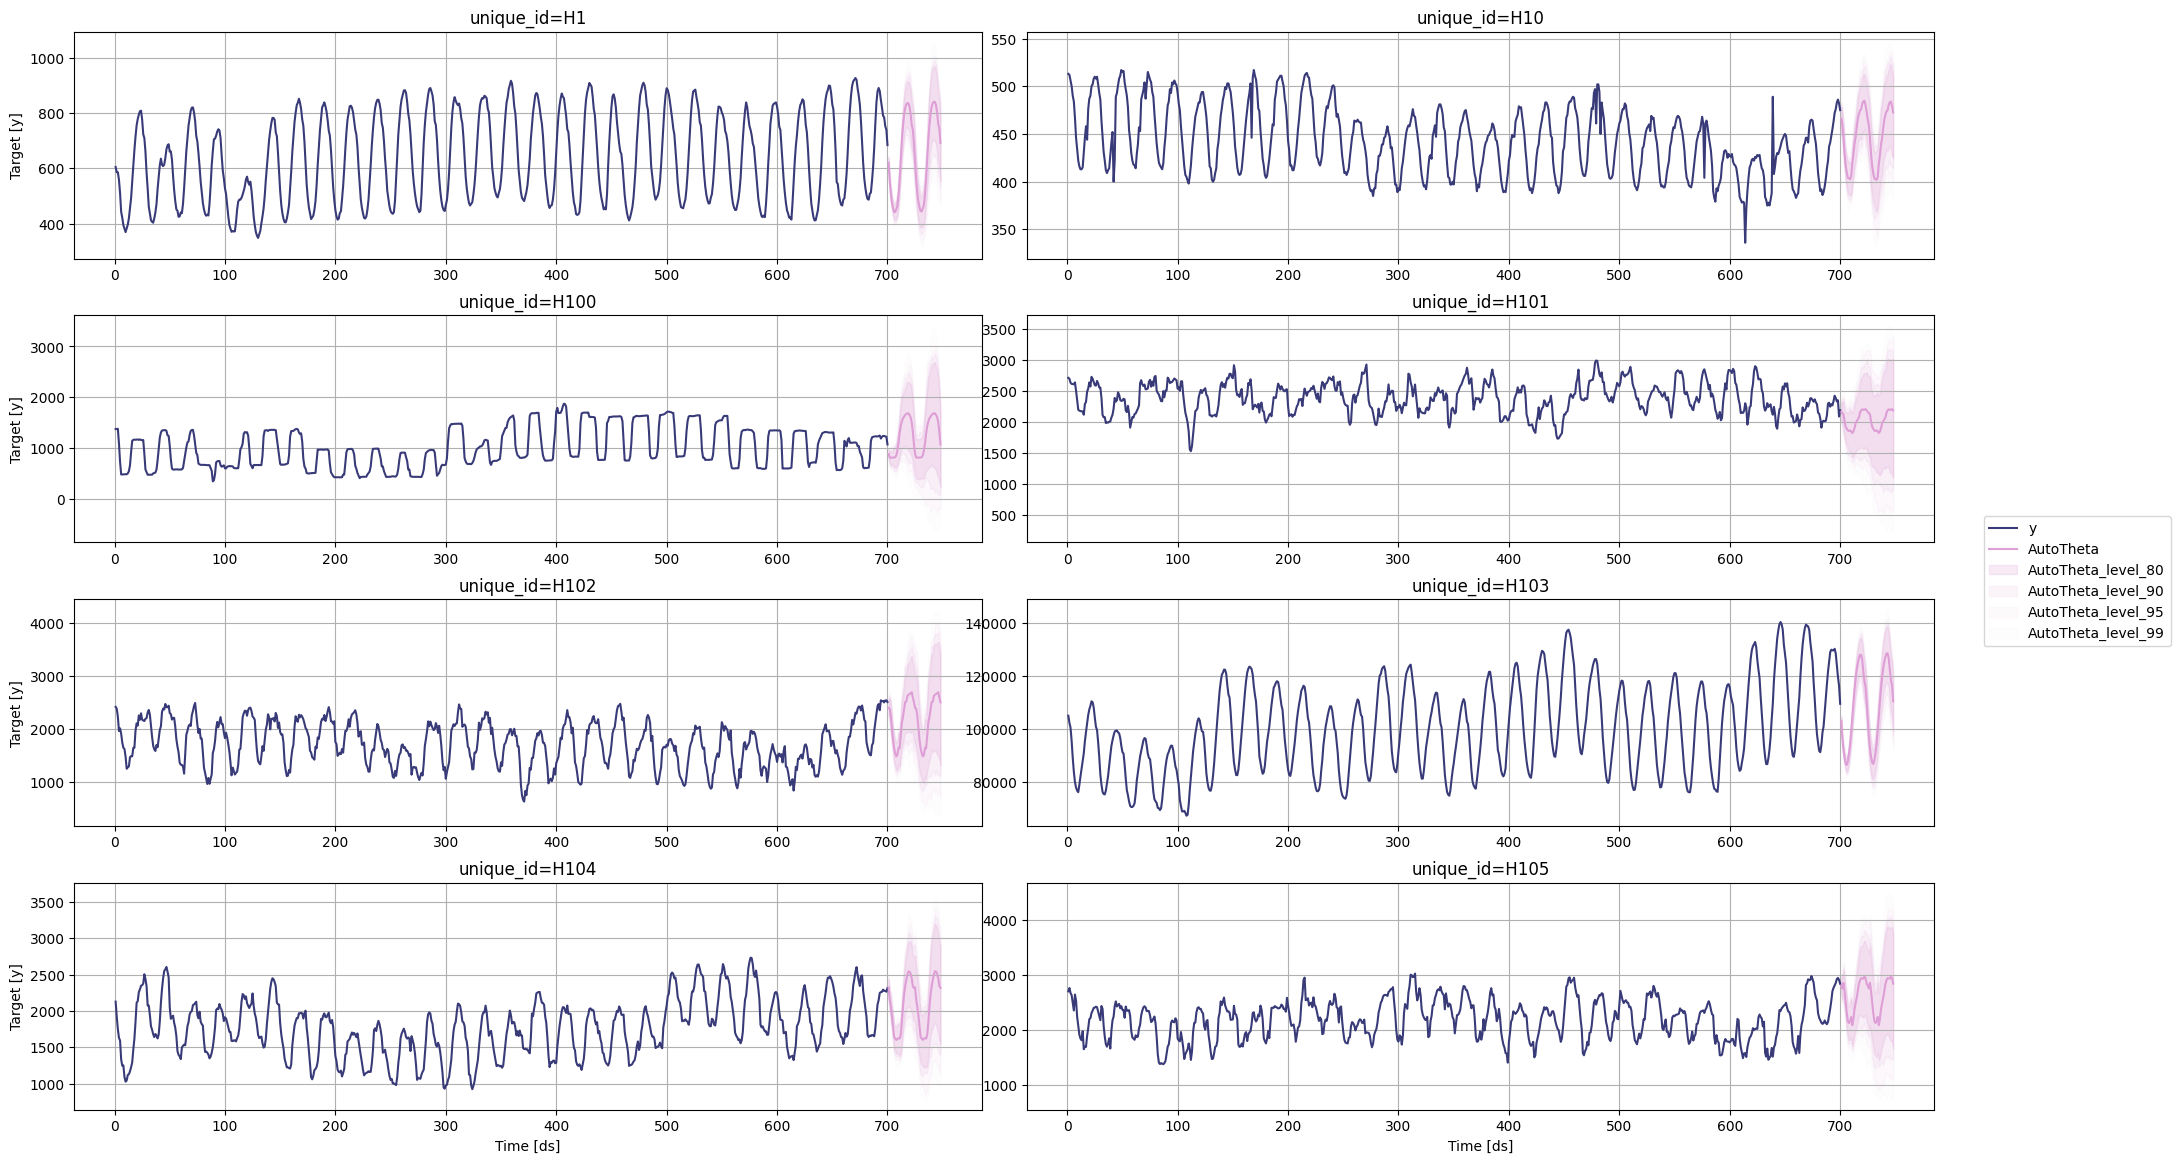

In [39]:
sf.plot(train, test, plot_random = False, models=['AutoTheta'], level=levels)

## AutoCES

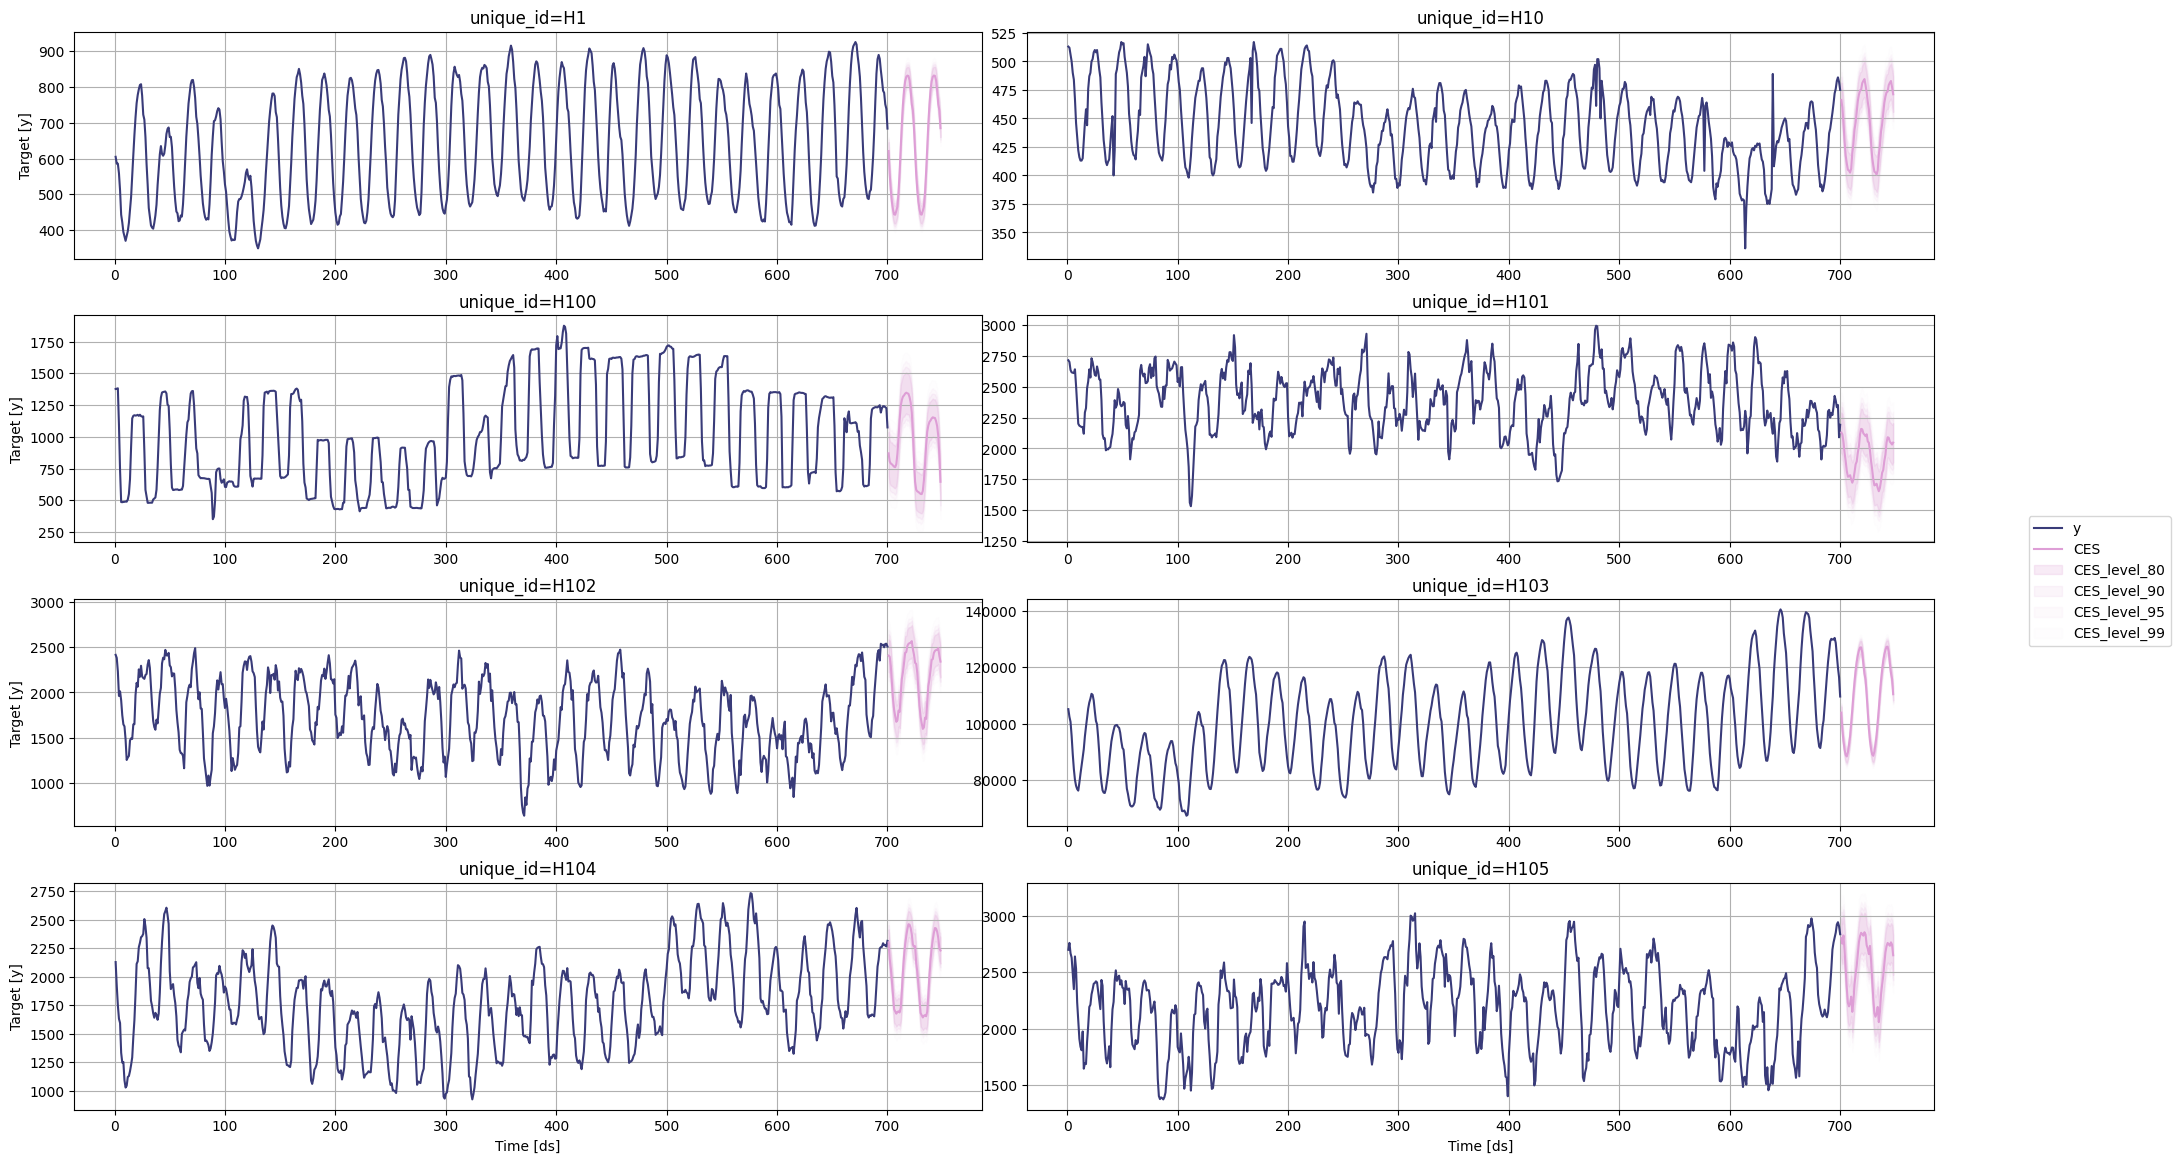

In [41]:
sf.plot(train, test, plot_random = False, models=['CES'], level=levels)

In [45]:
train.head()

unique_id  ds      y
0        H1   1  605.0
1        H1   2  586.0
2        H1   3  586.0
3        H1   4  559.0
4        H1   5  511.0

In [46]:
crossvaldation_df = sf.cross_validation(
    df=train,
    h=24,
    step_size=24,
    n_windows=2
)

/Users/jorge/Documents/vaforecast/.venv/lib/python3.11/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),
/Users/jorge/Documents/vaforecast/.venv/lib/python3.11/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),
/Users/jorge/Documents/vaforecast/.venv/lib/python3.11/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),
/Users/jorge/Documents/vaforecast/.venv/lib/python3.11/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version

In [49]:
crossvaldation_df

ds  cutoff       y   Naive  SeasonalNaive    AutoARIMA  \
unique_id                                                            
H1         653     652   664.0   749.0          594.0   676.885925   
H1         654     652   550.0   749.0          528.0   605.225952   
H1         655     652   544.0   749.0          474.0   548.944824   
H1         656     652   505.0   749.0          447.0   510.324646   
H1         657     652   483.0   749.0          423.0   480.898346   
...        ...     ...     ...     ...            ...          ...   
H105       696     676  2849.0  2854.0         2899.0  2478.339844   
H105       697     676  2921.0  2854.0         2907.0  2489.638672   
H105       698     676  2941.0  2854.0         2975.0  2571.954346   
H105       699     676  2905.0  2854.0         2919.0  2581.432373   
H105       700     676  2835.0  2854.0         2854.0  2508.873779   

               AutoETS    AutoTheta          CES  
unique_id                                         
H1          647.939148   680.279358   690.267578  
H1          586.819580   611.190552   627.684387  
H1          541.564209   560.538513   582.711792  
H1          511.078796   524.813293   550.434998  
H1          489.015594   501.560822   529.387390  
...                ...          ...          ...  
H105       2854.006592  2948.099121  2847.131348  
H105       2854.006592  2943.838623  2839.352783  
H105       2854.006592  2979.420654  2866.419189  
H105       2854.006592  2957.682861  2842.132812  
H105       2854.006592  2853.684326  2755.783691  

[384 rows x 9 columns]

In [47]:
from utilsforecast.losses import mse
from utilsforecast.evaluation import evaluate

def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.    
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

In [50]:
evaluation_df = evaluate_cross_validation(crossvaldation_df.reset_index(), mse)
evaluation_df.head()

Naive  SeasonalNaive      AutoARIMA        AutoETS  \
unique_id                                                               
H1          29639.707031    2767.333496    2086.615234    1468.125854   
H10          1239.562500     309.750000     158.400986     118.577515   
H100        86421.625000   24487.812500   20491.031250   85456.960938   
H101       122986.937500   24768.375000   47706.070312  122984.992188   
H102       196196.703125  137656.812500  228147.031250  196195.968750   

               AutoTheta            CES     best_model  
unique_id                                               
H1           2035.154785    2445.080566        AutoETS  
H10           119.628265     170.484802        AutoETS  
H100        96226.195312   45278.101562      AutoARIMA  
H101        40554.710938   33559.429688  SeasonalNaive  
H102       105046.382812  133823.062500      AutoTheta

In [56]:
#summary_df = evaluation_df.groupby('best_model').size().sort_values().to_frame()
#summary_df.reset_index().columns = ["Model", "Nr. of unique_ids"]
#seasonal_ids = evaluation_df.query('best_model == "SeasonalNaive"').index
# sf.plot(train,forecasts_df, unique_ids=seasonal_ids, models=["SeasonalNaive","DynamicOptimizedTheta"])

unique_id   ds  best_model  best_model-hi-90  best_model-lo-90
0        H1  701  631.889587        694.800354        568.978882
1        H1  702  559.750854        622.977295        496.524353
2        H1  703  519.235474        582.776123        455.694794
3        H1  704  486.973358        550.826660        423.120056
4        H1  705  464.697357        528.861755        400.532959

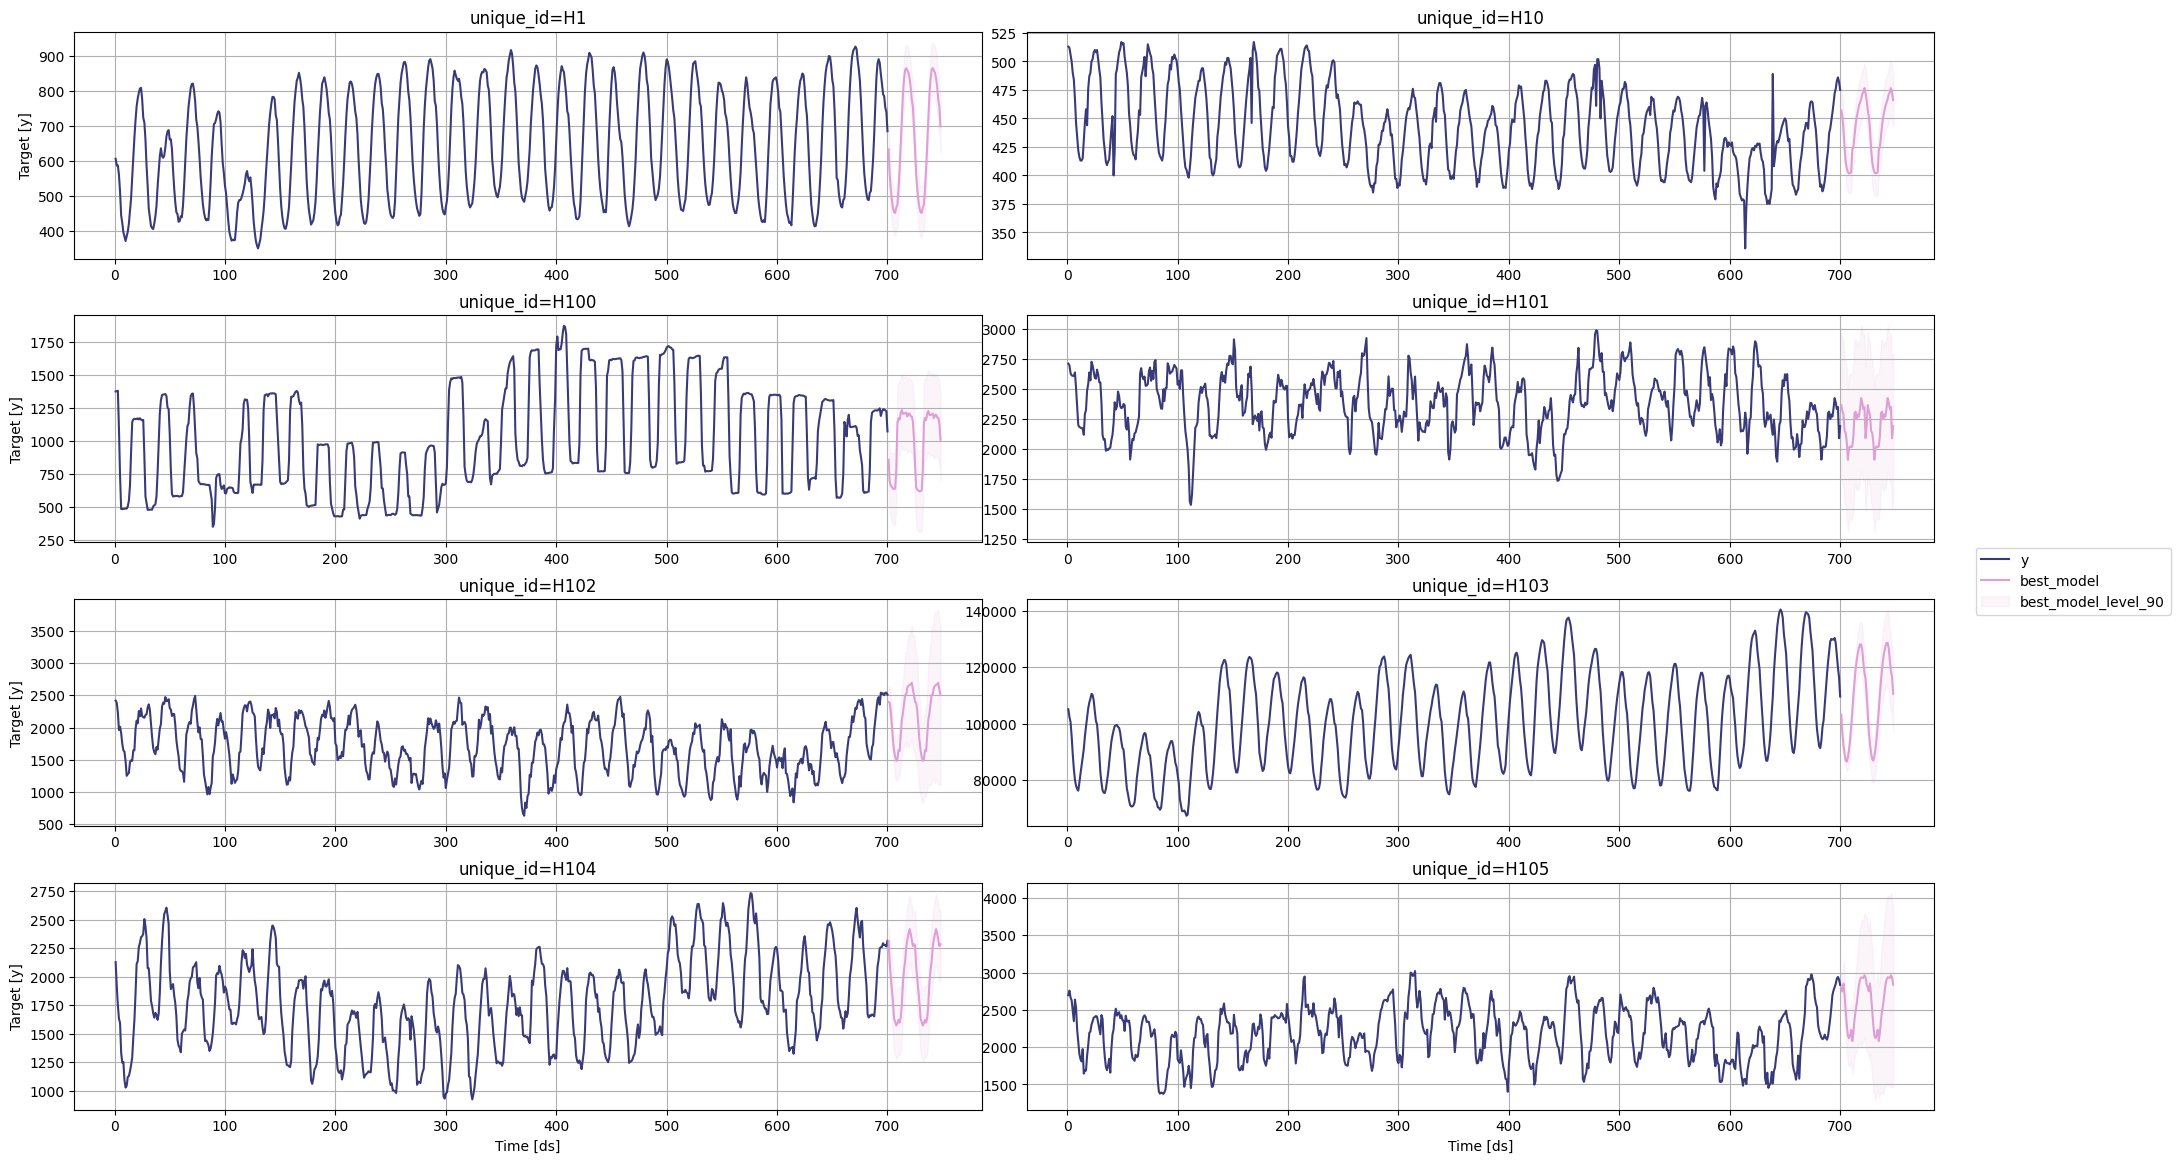

In [58]:
def get_best_model_forecast(forecasts_df, evaluation_df):
    df = forecasts_df.set_index(['unique_id', 'ds']).stack().to_frame().reset_index(level=2) # Wide to long 
    df.columns = ['model', 'best_model_forecast'] 
    df = df.join(evaluation_df[['best_model']])
    df = df.query('model.str.replace("-lo-90|-hi-90", "", regex=True) == best_model').copy()
    df.loc[:, 'model'] = [model.replace(bm, 'best_model') for model, bm in zip(df['model'], df['best_model'])]
    df = df.drop(columns='best_model').set_index('model', append=True).unstack()
    df.columns = df.columns.droplevel()
    df.columns.name = None
    df = df.reset_index()
    return df

prod_forecasts_df = get_best_model_forecast(forecasts, evaluation_df)
display(prod_forecasts_df.head())
sf.plot(train, test, prod_forecasts_df, level=[90])

In [65]:
dengue = pd.read_csv(_session_dir / "data" / "dengue_singapur_2012_2020.csv", index_col=0, parse_dates=['start_date', 'end_date'])
dengue.head()

epidemiology_weeks start_date   end_date  dengue  year
0                   1 2012-01-01 2012-01-07      74  2012
1                   2 2012-01-08 2012-01-14      64  2012
2                   3 2012-01-15 2012-01-21      60  2012
3                   4 2012-01-22 2012-01-28      50  2012
4                   5 2012-01-29 2012-02-04      84  2012

In [66]:
df = dengue.assign(unique_id='dengue', ds=dengue.end_date, y=dengue.dengue)[['unique_id','ds','y']].copy()
df['y'] = np.log(df['y'])
df.head()

unique_id         ds         y
0    dengue 2012-01-07  4.304065
1    dengue 2012-01-14  4.158883
2    dengue 2012-01-21  4.094345
3    dengue 2012-01-28  3.912023
4    dengue 2012-02-04  4.430817

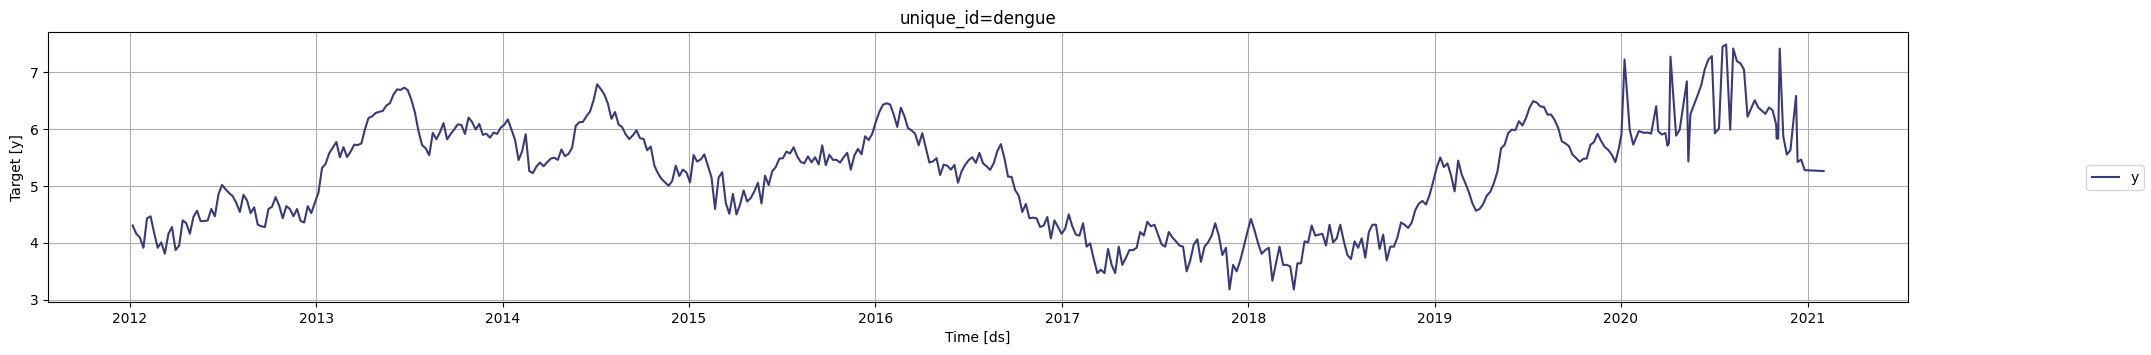

In [78]:
_dates = df['ds'].unique()
_dtrain = _dates[:-15]
_dtest = _dates[-15:]
y_train = df.query('ds in @_dtrain')
y_test = df.query('ds in @_dtest') 

# plot_series(df, max_insample_length=24 * 14, engine='matplotlib')
StatsForecast.plot(y_train, y_test)

In [83]:
sf_dengue = StatsForecast(
    models = [AutoTheta(season_length = 7), 
              AutoARIMA(season_length = 7),
              HistoricAverage(),
              SeasonalNaive(season_length=7)],
    freq = '1d',
    n_jobs=-1
)

sf_dengue.fit(y_train.dropna())
forecast_df = sf_dengue.predict(h=3*52, level=[90]) 
forecast_df.tail()

ds  AutoTheta  AutoTheta-lo-90  AutoTheta-hi-90  AutoARIMA  \
unique_id                                                                      
dengue    2021-02-25   6.491554         3.034209         9.583257   6.435017   
dengue    2021-02-26   6.473516         2.925928         9.525605   6.435017   
dengue    2021-02-27   6.411764         3.295676         9.488937   6.435017   
dengue    2021-02-28   6.453825         3.205697         9.815973   6.435017   
dengue    2021-03-01   6.375125         3.259427         9.495390   6.435017   

           AutoARIMA-lo-90  AutoARIMA-hi-90  HistoricAverage  \
unique_id                                                      
dengue            2.979104         9.890930         5.166498   
dengue            2.967873         9.902161         5.166498   
dengue            2.956678         9.913356         5.166498   
dengue            2.945519         9.924515         5.166498   
dengue            2.934396         9.935638         5.166498   

           HistoricAverage-lo-90  HistoricAverage-hi-90  SeasonalNaive  \
unique_id                                                                
dengue                  3.651298               6.681698       6.218600   
dengue                  3.651298               6.681698       6.508769   
dengue                  3.651298               6.681698       6.380123   
dengue                  3.651298               6.681698       7.418781   
dengue                  3.651298               6.681698       7.197435   

           SeasonalNaive-lo-90  SeasonalNaive-hi-90  
unique_id                                            
dengue                2.178025            10.259176  
dengue                2.468193            10.549345  
dengue                2.339547            10.420698  
dengue                3.378205            11.459356  
dengue                3.156860            11.238011

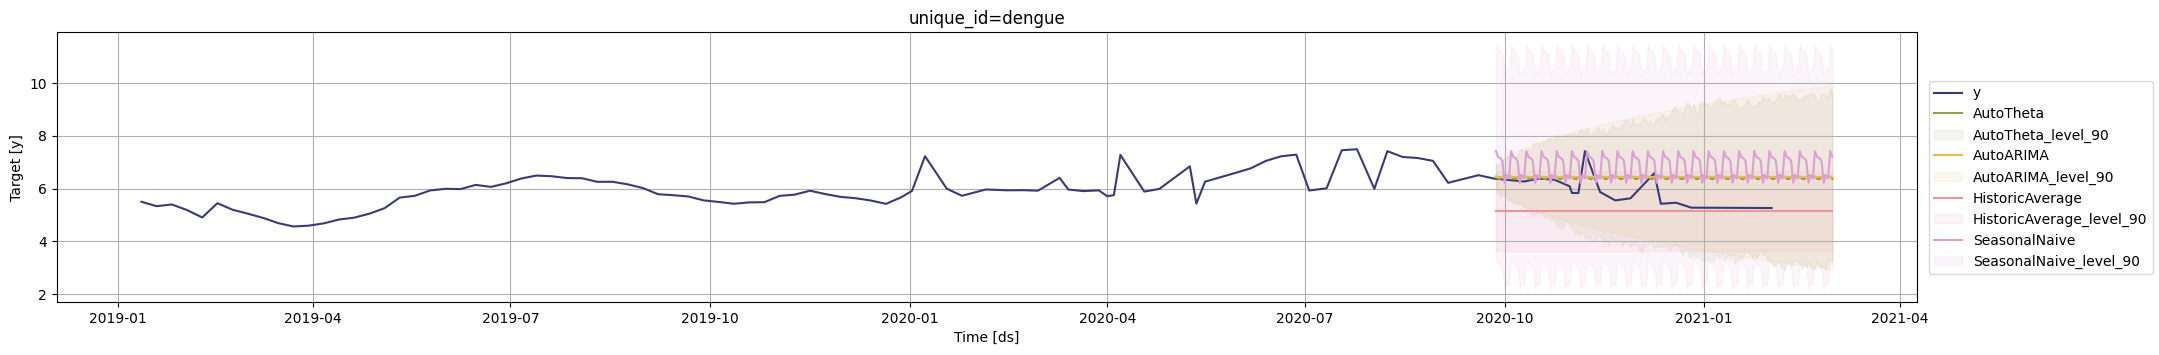

In [85]:
sf.plot(df, forecast_df, level=[90], max_insample_length=52*2)